In [12]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt

## Tempo medio de cada modelo por fontes

In [13]:
import glob
import pandas as pd

# Carregar todos os arquivos .jsonl
files = glob.glob('../logs/*.jsonl')

# Ler todos os arquivos e calcular média de duration_seconds
all_data = []
for file in files:
    df = pd.read_json(file, orient='records', lines=True)
    df = df[df['file'] != '']
    grouped = df.groupby(['model', 'mode', 'file', 'analysis'])['duration_seconds'].mean().reset_index()
    all_data.append(grouped)

# Concatenar tudo em um único DataFrame
duration = pd.concat(all_data, ignore_index=True)

# Função para processar e calcular a média geral de data/attack + data/safe agrupando pela fonte
def process_mode(df, mode):
    df_mode = df[df['mode'] == mode].copy()
    
    # Extrai a fonte principal (data, gemma3_4b, llama3.2_3b, etc.)
    df_mode['fonte'] = df_mode['file'].str.extract(
        r'(?:^|/)(data|gemma3_4b|llama3.2_3b|phi4-mini|tinyllama_1.1b|deepseek-r1_14b|gemma3_12b|llama3.1|mistral-nemo|phi4|qwen3_14b)(?=/)'
    )
    
    # Se não pegar nada, pode ser que a fonte seja 'data' na raiz
    df_mode['fonte'] = df_mode['fonte'].fillna('data')

    # Extrai attack ou safe para debug se quiser
    df_mode['tipo'] = df_mode['file'].str.extract(r'(attack|safe)')

    # Remove file para limpar
    df_mode.drop(columns='file', inplace=True)

    # Primeiro: debug opcional (se quiser ver attack/safe separados)
    grouped_detalhado = (
        df_mode.groupby(['model', 'mode', 'fonte', 'tipo'])['duration_seconds']
        .mean()
        .reset_index()
        .sort_values('duration_seconds')
    )

    # Agora: agrupa combinando attack + safe em uma só média geral por modelo + fonte
    grouped_total = (
        df_mode.groupby(['model', 'mode', 'fonte'])['duration_seconds']
        .mean()
        .reset_index()
        .sort_values(['fonte', 'duration_seconds'])
        .reset_index(drop=True)
    )
    
    return grouped_total

# Processar inference e filtering
time_models_inference = process_mode(duration, 'inference')
time_models_filtering = process_mode(duration, 'filtering')

# Exibir resultados finais
display(time_models_filtering.sort_values(['model', 'fonte']))
display(time_models_inference.sort_values(['model', 'fonte']))


,model,mode,fonte,duration_seconds
1,gemma3:4b,filtering,data,0.143057
0,llama3.2:3b,filtering,data,0.098010
2,phi4-mini,filtering,data,0.177983
3,tinyllama:1.1b,filtering,data,0.621052


,model,mode,fonte,duration_seconds
3,deepseek-r1:14b,inference,data,9.672395
10,deepseek-r1:14b,inference,gemma3_4b,8.601039
16,deepseek-r1:14b,inference,llama3.2_3b,8.650575
22,deepseek-r1:14b,inference,phi4-mini,8.173368
28,deepseek-r1:14b,inference,tinyllama_1.1b,8.104124
4,gemma3:12b,inference,data,12.002325
9,gemma3:12b,inference,gemma3_4b,5.607627
15,gemma3:12b,inference,llama3.2_3b,8.085032
21,gemma3:12b,inference,phi4-mini,4.859944
27,gemma3:12b,inference,tinyllama_1.1b,4.332132


## Precisão dos modelos por fontes

In [14]:
files = glob.glob(f'../logs/*.jsonl')

time = []
for file in files:
    model = pd.read_json(file, orient='records', lines=True)
    model = model[model['file'] != '']
    time.append(model.groupby(['model', 'mode', 'file', 'analysis'])['duration_seconds'].mean())

duration = pd.concat(time).reset_index()

duration_inference = duration[duration['mode'] == 'inference']

grupo_inference = duration_inference.groupby('model')[['model', 'mode', 'file', 'duration_seconds', 'analysis']]

models_inference = []
for _, grupo_df in grupo_inference:
    grupo_df['analysis'] = grupo_df['analysis'].str.replace(r'(?s)<think>.*?<\/think>', '', regex=True) # remover deepseek <think> 
    grupo_df['fonte'] = grupo_df['file'].str.replace(r'^filtering[/\\]', '', regex=True)
    grupo_df['model_font'] = grupo_df['file'].str.extract(r'(.*?/safe|.*?/attack)')
    grupo_df['model_font'] = grupo_df['model_font'].str.replace(r'(/safe|/attack|filtering/)', '', regex=True)
    grupo_df.drop('file', axis=1, inplace=True)
    models_inference.append(grupo_df)

inference = []
for model in models_inference:
    model['analysis'] = model['analysis'].apply(
        lambda x: 'NOT INTERESTING' if 'NOT INTERESTING' in x else (
            'INTERESTING' if 'INTERESTING' in x else 'NOT INTERESTING'
        )
    )
    analise_int = model[model['analysis'] == 'INTERESTING']
    analise_nint = model[model['analysis'] == 'NOT INTERESTING']

    soma_int = analise_int.groupby(['model', 'model_font', 'fonte']).size()
    soma_nint = analise_nint.groupby(['model','model_font', 'fonte']).size()

    soma_int = pd.DataFrame(soma_int).reset_index().rename(columns={0:"quantidade"})
    soma_nint = pd.DataFrame(soma_nint).reset_index().rename(columns={0:"quantidade"})
    total = pd.merge(soma_int, soma_nint, on=['model_font', 'fonte'], how='outer', suffixes=('_int', '_nint'))
    total.drop(columns='model_nint', inplace=True)
    total = total.fillna(0)

    total['porcentagem_int'] = total['quantidade_int']/(total['quantidade_int'] + total['quantidade_nint']) * 100

    def calcular_erro(row):
        if 'safe' in row['fonte']:
            # Se for scenario6 e a porcentagem >= 50, ele errou
            return 'FALSO POSITIVO' if row['porcentagem_int'] >= 50 else 'VERDADEIRO NEGATIVO'
        else:
            # Caso contrário, se a porcentagem >= 50, ele acertou
            return 'VERDADEIRO POSITIVO' if row['porcentagem_int'] >= 50 else 'FALSO NEGATIVO'

    total['resultado'] = total.apply(calcular_erro, axis=1)
    total['model_int'] = total['model_int'].replace(0, total['model_int'].iloc[0])
    inference.append(total)

juntar = []
for inf in inference:
    grupo = inf.groupby(['model_font'])['resultado'].value_counts().reset_index()
    grupo['model'] = inf['model_int'].iloc[0]
    
    resultado_pivot = grupo.pivot_table(index=['model_font', 'model'], 
                                    columns='resultado', 
                                    values='count', 
                                    aggfunc='sum', 
                                    fill_value=0).reset_index()

    # Renomeando as colunas para deixar mais claro
    resultado_pivot.columns.name = None  # Remove o nome do índice das colunas
    resultado_pivot = resultado_pivot.rename(columns={'FALSO POSITIVO': 'falso_positivo', 'VERDADEIRO NEGATIVO': 'verdadeiro_negativo', 'VERDADEIRO POSITIVO': 'verdadeiro_positivo', 'FALSO NEGATIVO': 'falso_negativo', 'INVALID': 'invalidos'})

    # Exibir o resultado final
    juntar.append(resultado_pivot)
    display(resultado_pivot)
    

,model_font,model,falso_negativo,falso_positivo,verdadeiro_negativo,verdadeiro_positivo
0,data,deepseek-r1:14b,6,3,16,26
1,gemma3_4b,deepseek-r1:14b,5,4,15,27
2,llama3.2_3b,deepseek-r1:14b,2,1,18,30
3,phi4-mini,deepseek-r1:14b,5,2,17,27
4,tinyllama_1.1b,deepseek-r1:14b,4,3,16,28


,model_font,model,falso_positivo,verdadeiro_negativo,verdadeiro_positivo
0,data,gemma3:12b,13,6,32
1,gemma3_4b,gemma3:12b,13,6,32
2,llama3.2_3b,gemma3:12b,14,5,32
3,phi4-mini,gemma3:12b,15,4,32
4,tinyllama_1.1b,gemma3:12b,15,4,32


,model_font,model,falso_positivo,verdadeiro_negativo,verdadeiro_positivo
0,data,llama3.1,17,2,32
1,gemma3_4b,llama3.1,17,2,32
2,llama3.2_3b,llama3.1,16,3,32
3,phi4-mini,llama3.1,17,2,32
4,tinyllama_1.1b,llama3.1,17,2,32


,model_font,model,falso_positivo,verdadeiro_negativo,verdadeiro_positivo
0,data,mistral-nemo,15,4,32
1,gemma3_4b,mistral-nemo,15,4,32
2,llama3.2_3b,mistral-nemo,14,5,32
3,phi4-mini,mistral-nemo,15,4,32
4,tinyllama_1.1b,mistral-nemo,15,4,32


,model_font,model,falso_positivo,verdadeiro_negativo,verdadeiro_positivo
0,data,phi4,15,4,32
1,gemma3_4b,phi4,13,6,32
2,llama3.2_3b,phi4,13,6,32
3,phi4-mini,phi4,14,5,32
4,tinyllama_1.1b,phi4,13,6,32


,model_font,model,falso_negativo,falso_positivo,verdadeiro_negativo,verdadeiro_positivo
0,data,qwen3:14b,11,3,16,21
1,gemma3_4b,qwen3:14b,8,6,13,24
2,llama3.2_3b,qwen3:14b,9,5,14,23
3,phi4-mini,qwen3:14b,12,5,14,20
4,tinyllama_1.1b,qwen3:14b,14,4,15,18


## Gerar gráficos

### Tempo de Analise

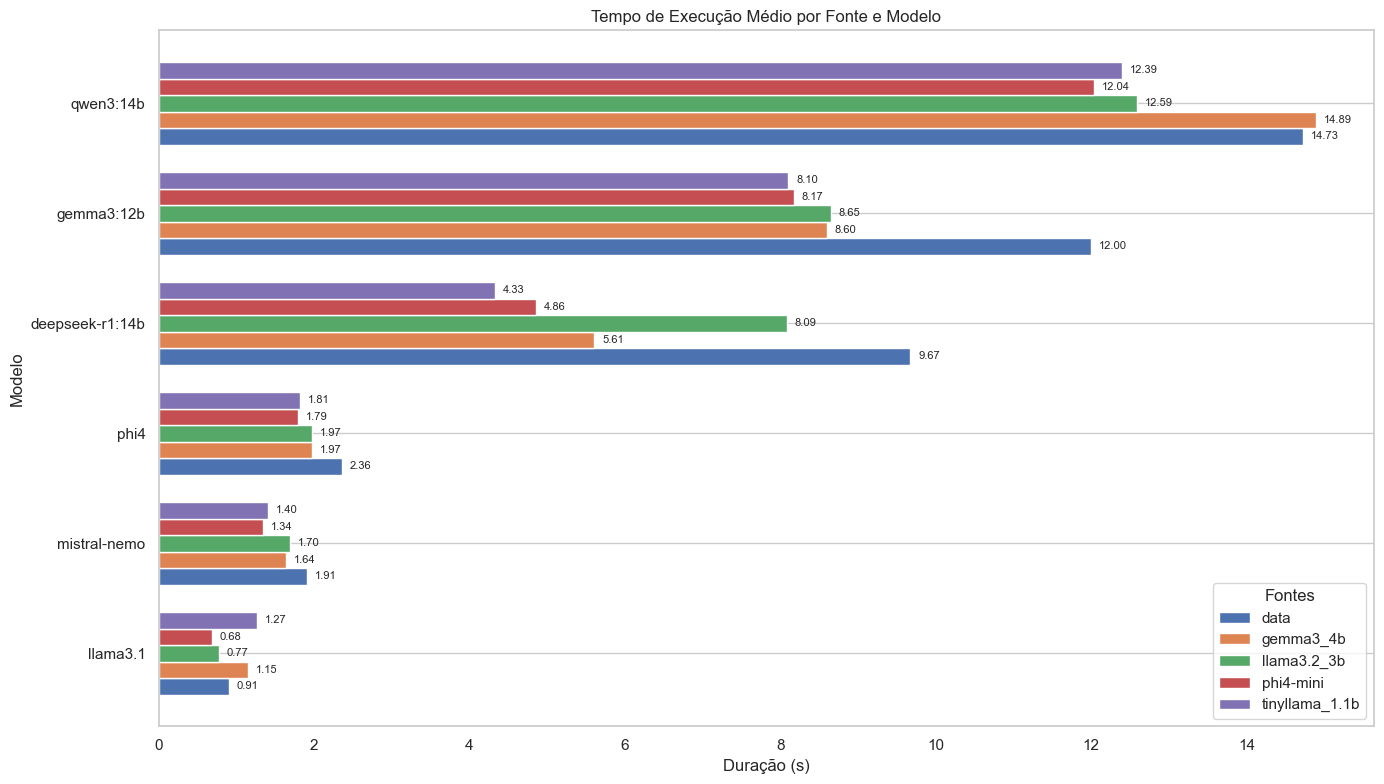

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = time_models_inference

# Pegar fontes e modelos únicos
fontes = df['fonte'].unique()
modelos = df['model'].unique()

# Configurar
y = np.arange(len(modelos))  # posição dos modelos no eixo Y
largura = 0.15  # largura de cada barra

plt.figure(figsize=(14, 8))

# Para cada fonte, desenhar as barras
for i, fonte in enumerate(fontes):
    df_fonte = df[df['fonte'] == fonte]
    barras = plt.barh(y + i*largura, df_fonte['duration_seconds'], height=largura, label=fonte)
    
    # Adicionar o valor ao lado de cada barra
    for bar in barras:
        largura_barra = bar.get_width()
        plt.text(
            largura_barra + 0.1,  # posição x (um pouco à direita da barra)
            bar.get_y() + bar.get_height()/2,  # posição y (centro da barra)
            f'{largura_barra:.2f}',  # valor formatado
            va='center', fontsize=8
        )

# Personalizar
plt.ylabel('Modelo')
plt.xlabel('Duração (s)')
plt.title('Tempo de Execução Médio por Fonte e Modelo')
plt.yticks(y + largura * (len(fontes)-1)/2, modelos)
plt.legend(title='Fontes')
plt.grid(axis='x')
plt.tight_layout()

plt.savefig('result/tempo_inferencia_por_fonte')
plt.show()


### Inferencias

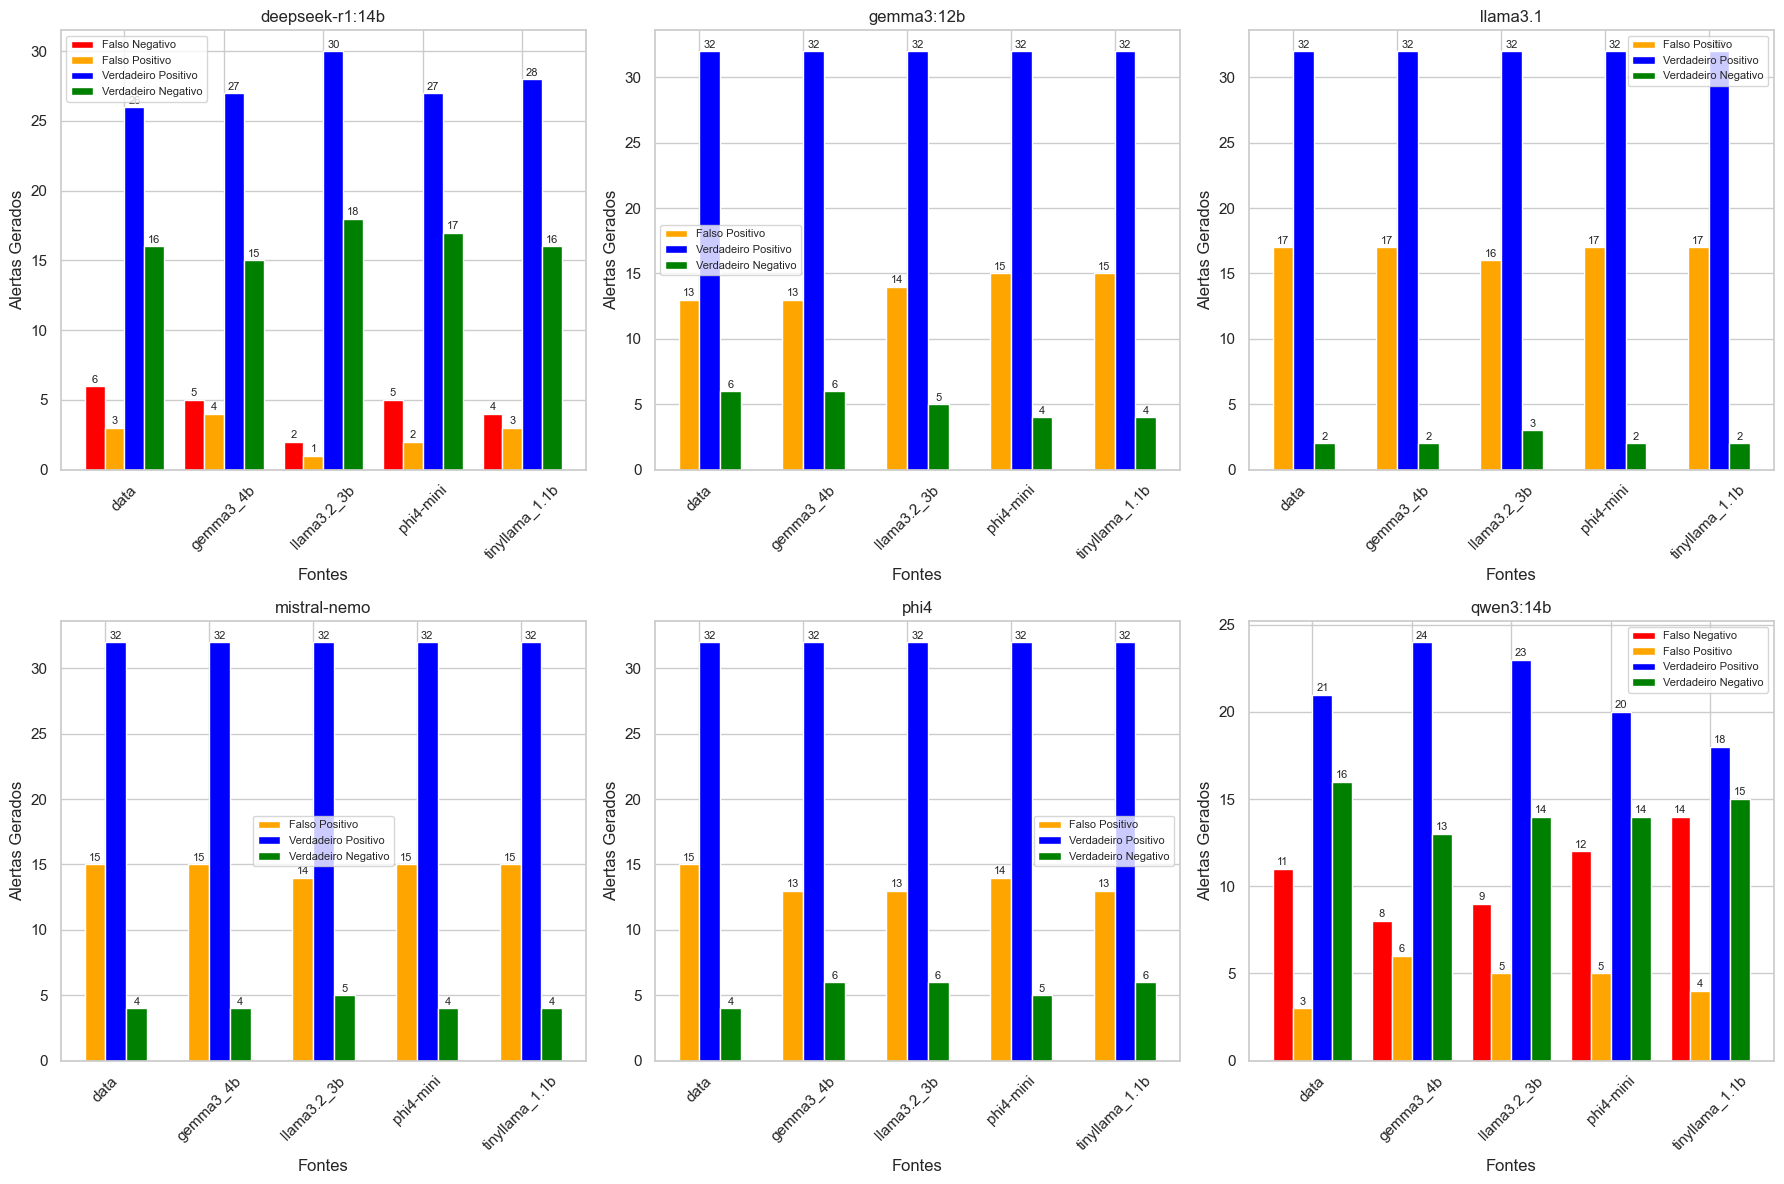

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

# Número de gráficos
n = len(juntar)

# Definir número de colunas (ajustável conforme necessidade)
num_cols = 3  # ou 2, 4, conforme o espaço
num_rows = math.ceil(n / num_cols)

# Criar os subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(6 * num_cols, 6 * num_rows))
axs = axs.flatten()  # Facilita o acesso aos eixos

for i, df in enumerate(juntar):
    ax = axs[i]
    bar_width = 0.2
    index = np.arange(len(df))

    if 'falso_negativo' in df.columns:
        bars_fn = ax.bar(index, df['falso_negativo'], bar_width, label='Falso Negativo', color='red')
        for bar in bars_fn:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f'{bar.get_height():.0f}', 
                    ha='center', va='bottom', fontsize=8)

    if 'falso_positivo' in df.columns:
        bars_fp = ax.bar(index + 1 * bar_width, df['falso_positivo'], bar_width, label='Falso Positivo', color='orange')
        for bar in bars_fp:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f'{bar.get_height():.0f}', 
                    ha='center', va='bottom', fontsize=8)

    if 'verdadeiro_positivo' in df.columns:
        bars_vp = ax.bar(index + 2 * bar_width, df['verdadeiro_positivo'], bar_width, label='Verdadeiro Positivo', color='blue')
        for bar in bars_vp:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f'{bar.get_height():.0f}', 
                    ha='center', va='bottom', fontsize=8)

    if 'verdadeiro_negativo' in df.columns:
        bars_vn = ax.bar(index + 3 * bar_width, df['verdadeiro_negativo'], bar_width, label='Verdadeiro Negativo', color='green')
        for bar in bars_vn:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f'{bar.get_height():.0f}', 
                    ha='center', va='bottom', fontsize=8)

    ax.set_xlabel('Fontes')
    ax.set_ylabel('Alertas Gerados')
    ax.set_title(f'{df["model"].iloc[0]}')
    ax.set_xticks(index + 1.5 * bar_width)
    ax.set_xticklabels(df['model_font'], rotation=45)
    ax.legend(fontsize=8)

# Remove subplots extras, caso existam
for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.savefig('result/inferencias_em_grade.png')
plt.show()


## Gerar tabelas

### Tabela de Inferências

#### Voto Majoritário

In [17]:
import numpy as np
import pandas as pd

colunas_esperadas = ['falso_negativo', 'falso_positivo', 'verdadeiro_positivo', 'verdadeiro_negativo']
result_model = []

for df in juntar:
    # Garantir que todas as colunas existam
    for coluna in colunas_esperadas:
        if coluna not in df.columns:
            df[coluna] = 0

    # Evitar divisões por zero
    total = df['verdadeiro_positivo'] + df['verdadeiro_negativo'] + df['falso_positivo'] + df['falso_negativo']
    df['acuracia'] = (df['verdadeiro_positivo'] + df['verdadeiro_negativo']) / total.replace(0, np.nan)

    df['precisao'] = df['verdadeiro_positivo'] / (
        df['verdadeiro_positivo'] + df['falso_positivo']
    ).replace(0, np.nan)

    df['recall'] = df['verdadeiro_positivo'] / (
        df['verdadeiro_positivo'] + df['falso_negativo']
    ).replace(0, np.nan)

    df['f1_score'] = 2 * (df['precisao'] * df['recall']) / (
        df['precisao'] + df['recall']
    ).replace(0, np.nan)

    df_res = df[['model', 'model_font', 'acuracia', 'precisao', 'recall', 'f1_score']]
    result_model.append(df_res)

# Concatenar todos os resultados
df_concat = pd.concat(result_model, ignore_index=True)

models_inference_df = pd.DataFrame(time_models_inference)

# Verificar se as colunas existem antes do merge
if {'model', 'fonte', 'duration_seconds'}.issubset(models_inference_df.columns):
    df_concat = df_concat.merge(
        models_inference_df[['model', 'fonte', 'duration_seconds']],
        left_on=['model', 'model_font'],
        right_on=['model', 'fonte'],
        how='left'
    )
else:
    print(models_inference_df.columns)
    print("❌ models_inference_df não contém as colunas necessárias.")

df_concat = df_concat[['model', 'fonte', 'acuracia', 'precisao', 'recall', 'f1_score', 'duration_seconds']].rename(columns={'model': 'modelo', 'duration_seconds':'tempo'})
df_concat.reset_index(drop=True)
df_concat.to_csv('result/tabela_inferencia.csv', sep=';', index=False, decimal=',')


#### Voto Majoritario

In [18]:
# Conta as análises por arquivo (file) agrupando pelos votantes
votantes = ['deepseek-r1:14b', 'qwen3:14b', 'gemma3:12b']
dados_voto = duration_inference[duration_inference['model'].isin(votantes)].copy()

dados_voto['analysis'] = dados_voto['analysis'].str.replace(r'(?s)<think>.*?<\/think>', '', regex=True)
dados_voto['analysis'] = dados_voto['analysis'].apply(
    lambda x: 'NOT INTERESTING' if 'NOT INTERESTING' in x else (
        'INTERESTING' if 'INTERESTING' in x else 'NOT INTERESTING'
    )
)

dados_voto['fonte'] = dados_voto['file'].str.replace(r'^filtering[/\\]', '', regex=True)
dados_voto['model_font'] = dados_voto['file'].str.extract(r'(.*?/safe|.*?/attack)')
dados_voto['model_font'] = dados_voto['model_font'].str.replace(r'(/safe|/attack|filtering/)', '', regex=True)


voto_majoritario = dados_voto.groupby(['model_font', 'fonte', 'analysis']).size().reset_index(name='count')

# Pivotar para INTERESTING / NOT INTERESTING em colunas
pivot_voto = voto_majoritario.pivot_table(
    index=['model_font', 'fonte'],
    columns='analysis',
    values='count',
    fill_value=0
).reset_index()

# Se quiser, padronizar nomes das colunas
pivot_voto = pivot_voto.rename(columns={
    'INTERESTING': 'votos_interesting',
    'NOT INTERESTING': 'votos_not_interesting'
})

# Definir quem venceu o voto majoritário
def decidir_voto(row):
    if row.get('votos_interesting', 0) >= row.get('votos_not_interesting', 0):
        return 'INTERESTING'
    elif row.get('votos_interesting', 0) < row.get('votos_not_interesting', 0):
        return 'NOT INTERESTING'
    else:
        return 'EMPATE'

pivot_voto['resultado_voto'] = pivot_voto.apply(decidir_voto, axis=1)


def calcular_erro_voto(row):
    if 'safe' in row['fonte']:
        return 'FALSO POSITIVO' if row['resultado_voto'] == 'INTERESTING' else 'VERDADEIRO NEGATIVO'
    else:
        return 'VERDADEIRO POSITIVO' if row['resultado_voto'] == 'INTERESTING' else 'FALSO NEGATIVO'

pivot_voto['resultado_final'] = pivot_voto.apply(calcular_erro_voto, axis=1)

# Contar os resultados finais para montar a matriz de confusão
confusao_voto = pivot_voto.groupby('model_font')['resultado_final'].value_counts().reset_index(name='count')

# Pivot para criar colunas separadas
resultado_pivot_voto = confusao_voto.pivot_table(
    index='model_font',
    columns='resultado_final',
    values='count',
    aggfunc='sum',
    fill_value=0
).reset_index()

# Renomear colunas para padronizar
resultado_pivot_voto = resultado_pivot_voto.rename(columns={
    'FALSO POSITIVO': 'falso_positivo',
    'VERDADEIRO NEGATIVO': 'verdadeiro_negativo',
    'VERDADEIRO POSITIVO': 'verdadeiro_positivo',
    'FALSO NEGATIVO': 'falso_negativo',
    'INVALID': 'invalidos'  # se tiver casos inválidos
})

import numpy as np

colunas_esperadas = ['falso_negativo', 'falso_positivo', 'verdadeiro_positivo', 'verdadeiro_negativo']

# Se você tiver apenas 1 DataFrame (resultado_pivot_voto), não precisa de loop
df = resultado_pivot_voto.copy()

# Garantir que todas as colunas existam
for coluna in colunas_esperadas:
    if coluna not in df.columns:
        df[coluna] = 0

# Evitar divisões por zero
total = df['verdadeiro_positivo'] + df['verdadeiro_negativo'] + df['falso_positivo'] + df['falso_negativo']
df['acuracia'] = (df['verdadeiro_positivo'] + df['verdadeiro_negativo']) / total.replace(0, np.nan)

df['precisao'] = df['verdadeiro_positivo'] / (
    df['verdadeiro_positivo'] + df['falso_positivo']
).replace(0, np.nan)

df['recall'] = df['verdadeiro_positivo'] / (
    df['verdadeiro_positivo'] + df['falso_negativo']
).replace(0, np.nan)

df['f1_score'] = 2 * (df['precisao'] * df['recall']) / (
    df['precisao'] + df['recall']
).replace(0, np.nan)

# Caso queira adicionar uma coluna 'model' com o nome 'voto_majoritario'
df['modelo'] = 'voto_majoritario'


df_res_voto = df[['modelo', 'model_font', 'acuracia', 'precisao', 'recall', 'f1_score']]
df_res_voto = df_res_voto.rename(columns={'model_font': 'fonte'})
df_res_voto.columns.name = None

df1 = pd.concat([df_concat, df_res_voto])

display(df1)

dfs_por_fonte = {
    fonte: grupo.reset_index(drop=True)
    for fonte, grupo in df1.groupby('fonte')
}

df1.to_csv("result/tabela_total.csv", sep=';', index=False, decimal=',')

,modelo,fonte,acuracia,precisao,recall,f1_score,tempo
0,deepseek-r1:14b,data,0.823529,0.896552,0.81250,0.852459,9.672395
1,deepseek-r1:14b,gemma3_4b,0.823529,0.870968,0.84375,0.857143,8.601039
2,deepseek-r1:14b,llama3.2_3b,0.941176,0.967742,0.93750,0.952381,8.650575
3,deepseek-r1:14b,phi4-mini,0.862745,0.931034,0.84375,0.885246,8.173368
4,deepseek-r1:14b,tinyllama_1.1b,0.862745,0.903226,0.87500,0.888889,8.104124
5,gemma3:12b,data,0.745098,0.711111,1.00000,0.831169,12.002325
6,gemma3:12b,gemma3_4b,0.745098,0.711111,1.00000,0.831169,5.607627
7,gemma3:12b,llama3.2_3b,0.725490,0.695652,1.00000,0.820513,8.085032
8,gemma3:12b,phi4-mini,0.705882,0.680851,1.00000,0.810127,4.859944
9,gemma3:12b,tinyllama_1.1b,0.705882,0.680851,1.00000,0.810127,4.332132


In [19]:
lista_dfs = []

for fonte, df in dfs_por_fonte.items():
    # Adiciona uma coluna extra para saber a fonte
    df_copy = df.copy()
    df_copy['fonte'] = fonte
    lista_dfs.append(df_copy)

# Junta tudo em um DataFrame só
df_comparativo = pd.concat(lista_dfs, ignore_index=True)

# Verificar como ficou
display(df_comparativo)

,modelo,fonte,acuracia,precisao,recall,f1_score,tempo
0,deepseek-r1:14b,data,0.823529,0.896552,0.81250,0.852459,9.672395
1,gemma3:12b,data,0.745098,0.711111,1.00000,0.831169,12.002325
2,llama3.1,data,0.666667,0.653061,1.00000,0.790123,0.907827
3,mistral-nemo,data,0.705882,0.680851,1.00000,0.810127,1.909505
4,phi4,data,0.705882,0.680851,1.00000,0.810127,2.361301
5,qwen3:14b,data,0.725490,0.875000,0.65625,0.750000,14.726888
6,voto_majoritario,data,0.803922,0.789474,0.93750,0.857143,NaN
7,deepseek-r1:14b,gemma3_4b,0.823529,0.870968,0.84375,0.857143,8.601039
8,gemma3:12b,gemma3_4b,0.745098,0.711111,1.00000,0.831169,5.607627
9,llama3.1,gemma3_4b,0.666667,0.653061,1.00000,0.790123,1.148791


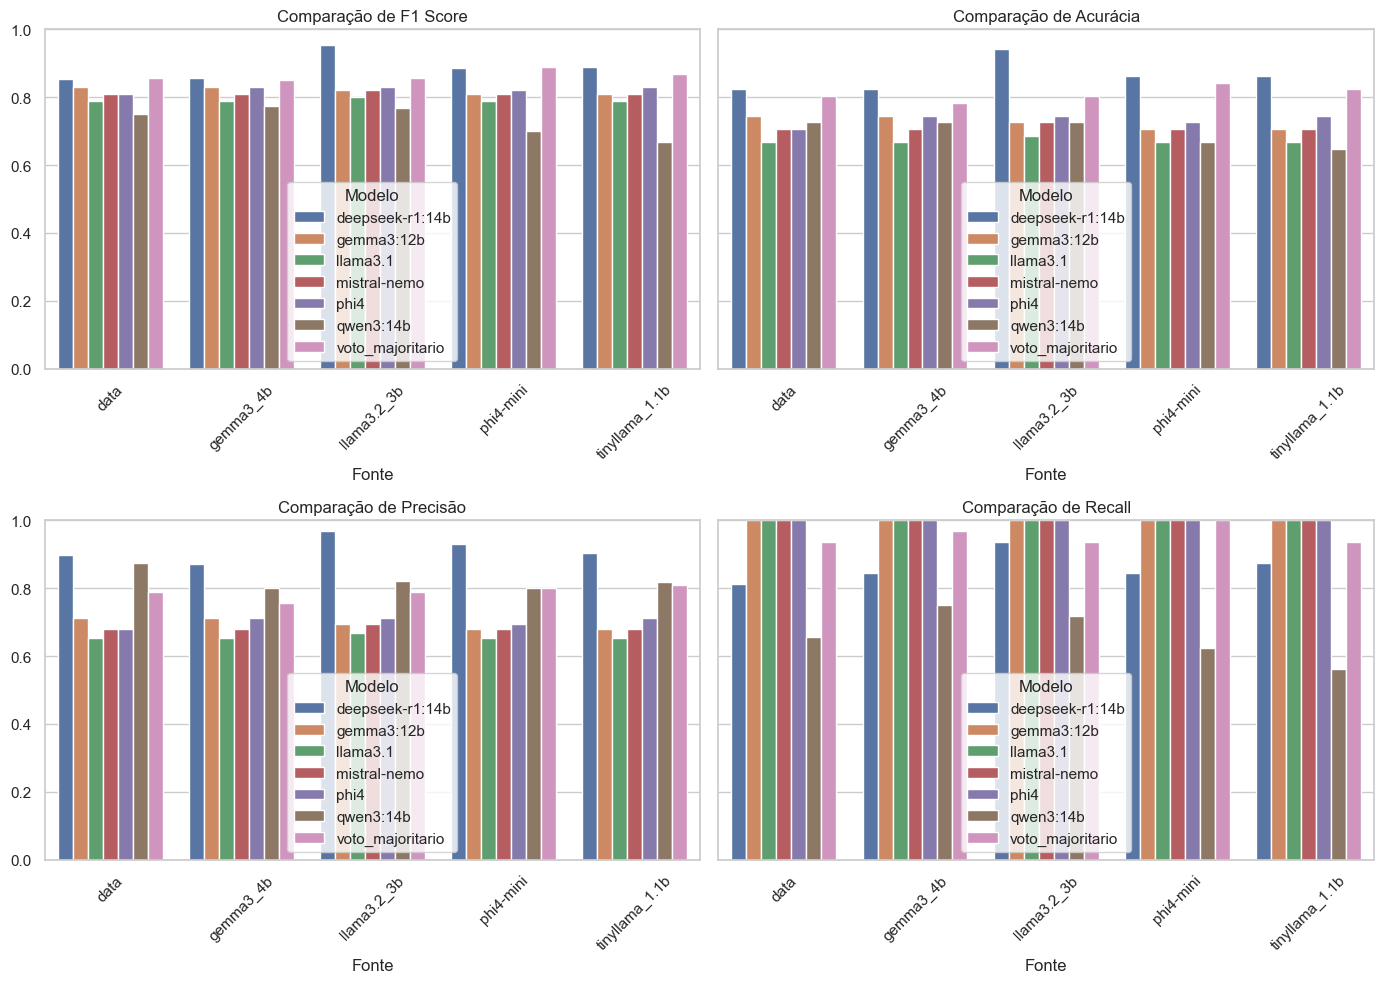

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Lista de métricas que você quer comparar
metricas = ['f1_score', 'acuracia', 'precisao', 'recall']
titulos = ['F1 Score', 'Acurácia', 'Precisão', 'Recall']

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)
axes = axes.flatten()  # para iterar fácil depois
for ax, metrica, titulo in zip(axes, metricas, titulos):
    sns.barplot(
        data=df_comparativo,
        x='fonte',
        y=metrica,
        hue='modelo',
        dodge=True,
        ax=ax
    )
    ax.set_title(f'Comparação de {titulo}')
    ax.set_ylabel('')
    ax.set_xlabel('Fonte')
    ax.set_ylim(0, 1)
    ax.legend().set_title('Modelo')
    ax.tick_params(axis='x', rotation=45)

# Ajustar layout para não cortar nada
plt.yticks()
plt.tight_layout()
plt.show()


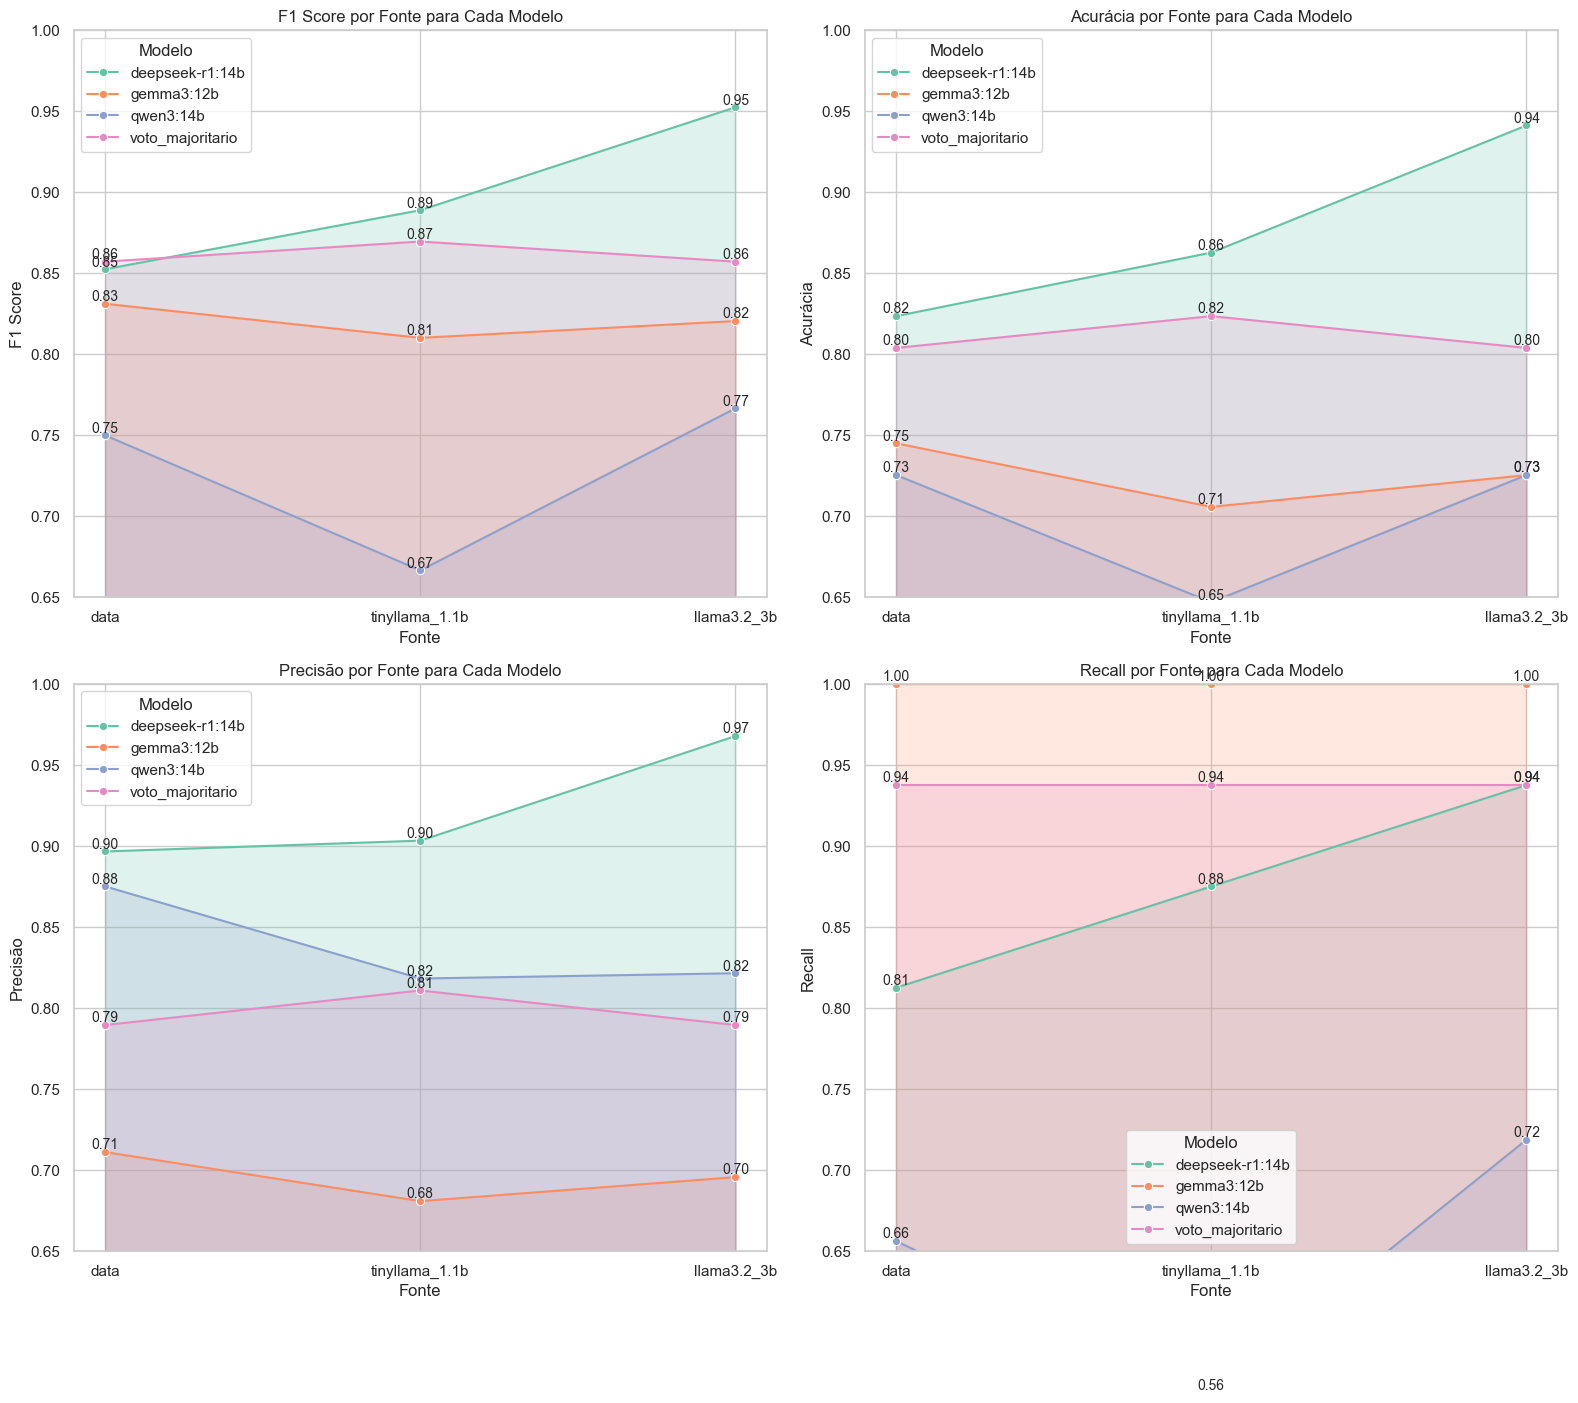

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set(style="whitegrid")

# Ajuste da paleta para só 4 cores (para limpar warning)
palette = sns.color_palette("Set2", n_colors=4)

# Filtros
filtros_fontes = ['data', 'tinyllama_1.1b', 'llama3.2_3b']
filtros_modelos = ['deepseek-r1:14b', 'qwen3:14b', 'gemma3:12b', 'voto_majoritario']

df_filtrado = df1[
    (df1['fonte'].isin(filtros_fontes)) &
    (df1['modelo'].isin(filtros_modelos))
].copy()

df_filtrado['fonte'] = pd.Categorical(
    df_filtrado['fonte'],
    categories=filtros_fontes,
    ordered=True
)

# Métricas que você quer plotar
metricas = ['f1_score', 'acuracia', 'precisao', 'recall']
titulos = ['F1 Score', 'Acurácia', 'Precisão', 'Recall']

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

for idx, (metrica, titulo) in enumerate(zip(metricas, titulos)):
    ax = axes[idx]
    
    # Plotar a linha normalmente (X = fonte, linhas = modelos)
    sns.lineplot(
        data=df_filtrado,
        x='fonte',
        y=metrica,
        hue='modelo',
        marker='o',
        palette=palette,
        ax=ax
    )
    
    # Loop para cada modelo (para o fill_between)
    for i, (modelo, grupo) in enumerate(df_filtrado.groupby('modelo')):
        grupo = grupo.sort_values('fonte')
        x_numerico = range(len(grupo))
        
        ax.fill_between(
            x_numerico,
            grupo[metrica],
            0.6,  # valor base
            alpha=0.2,
            color=palette[i % len(palette)]
        )
        
        # Adicionar texto nos pontos
        for x_pos, (fonte, y) in zip(x_numerico, zip(grupo['fonte'], grupo[metrica])):
            ax.text(
                x_pos,
                y,
                f"{y:.2f}",
                fontsize=10,
                ha='center',
                va='bottom'
            )
    
    ax.set_title(f'{titulo} por Fonte para Cada Modelo')
    ax.set_xlabel('Fonte')
    ax.set_ylabel(titulo)
    ax.set_ylim(0.65, 1)
    ax.set_xticks(ticks=range(len(filtros_fontes)))
    ax.set_xticklabels(filtros_fontes)
    ax.grid(True)
    
    ax.legend(title='Modelo')


plt.tight_layout()
plt.show()


,model_font,model,falso_negativo,falso_positivo,verdadeiro_negativo,verdadeiro_positivo,acuracia,precisao,recall,f1_score
0,data,deepseek-r1:14b,6,3,16,26,0.823529,0.896552,0.81250,0.852459
1,gemma3_4b,deepseek-r1:14b,5,4,15,27,0.823529,0.870968,0.84375,0.857143
2,llama3.2_3b,deepseek-r1:14b,2,1,18,30,0.941176,0.967742,0.93750,0.952381
3,phi4-mini,deepseek-r1:14b,5,2,17,27,0.862745,0.931034,0.84375,0.885246
4,tinyllama_1.1b,deepseek-r1:14b,4,3,16,28,0.862745,0.903226,0.87500,0.888889


,model_font,model,falso_positivo,verdadeiro_negativo,verdadeiro_positivo,falso_negativo,acuracia,precisao,recall,f1_score
0,data,gemma3:12b,13,6,32,0,0.745098,0.711111,1.0,0.831169
1,gemma3_4b,gemma3:12b,13,6,32,0,0.745098,0.711111,1.0,0.831169
2,llama3.2_3b,gemma3:12b,14,5,32,0,0.725490,0.695652,1.0,0.820513
3,phi4-mini,gemma3:12b,15,4,32,0,0.705882,0.680851,1.0,0.810127
4,tinyllama_1.1b,gemma3:12b,15,4,32,0,0.705882,0.680851,1.0,0.810127


,model_font,model,falso_positivo,verdadeiro_negativo,verdadeiro_positivo,falso_negativo,acuracia,precisao,recall,f1_score
0,data,llama3.1,17,2,32,0,0.666667,0.653061,1.0,0.790123
1,gemma3_4b,llama3.1,17,2,32,0,0.666667,0.653061,1.0,0.790123
2,llama3.2_3b,llama3.1,16,3,32,0,0.686275,0.666667,1.0,0.800000
3,phi4-mini,llama3.1,17,2,32,0,0.666667,0.653061,1.0,0.790123
4,tinyllama_1.1b,llama3.1,17,2,32,0,0.666667,0.653061,1.0,0.790123


,model_font,model,falso_positivo,verdadeiro_negativo,verdadeiro_positivo,falso_negativo,acuracia,precisao,recall,f1_score
0,data,mistral-nemo,15,4,32,0,0.705882,0.680851,1.0,0.810127
1,gemma3_4b,mistral-nemo,15,4,32,0,0.705882,0.680851,1.0,0.810127
2,llama3.2_3b,mistral-nemo,14,5,32,0,0.725490,0.695652,1.0,0.820513
3,phi4-mini,mistral-nemo,15,4,32,0,0.705882,0.680851,1.0,0.810127
4,tinyllama_1.1b,mistral-nemo,15,4,32,0,0.705882,0.680851,1.0,0.810127


,model_font,model,falso_positivo,verdadeiro_negativo,verdadeiro_positivo,falso_negativo,acuracia,precisao,recall,f1_score
0,data,phi4,15,4,32,0,0.705882,0.680851,1.0,0.810127
1,gemma3_4b,phi4,13,6,32,0,0.745098,0.711111,1.0,0.831169
2,llama3.2_3b,phi4,13,6,32,0,0.745098,0.711111,1.0,0.831169
3,phi4-mini,phi4,14,5,32,0,0.725490,0.695652,1.0,0.820513
4,tinyllama_1.1b,phi4,13,6,32,0,0.745098,0.711111,1.0,0.831169


,model_font,model,falso_negativo,falso_positivo,verdadeiro_negativo,verdadeiro_positivo,acuracia,precisao,recall,f1_score
0,data,qwen3:14b,11,3,16,21,0.725490,0.875000,0.65625,0.750000
1,gemma3_4b,qwen3:14b,8,6,13,24,0.725490,0.800000,0.75000,0.774194
2,llama3.2_3b,qwen3:14b,9,5,14,23,0.725490,0.821429,0.71875,0.766667
3,phi4-mini,qwen3:14b,12,5,14,20,0.666667,0.800000,0.62500,0.701754
4,tinyllama_1.1b,qwen3:14b,14,4,15,18,0.647059,0.818182,0.56250,0.666667


,model_font,falso_negativo,falso_positivo,verdadeiro_negativo,verdadeiro_positivo,model
0,data,2,8,11,30,voto_majoritario
1,gemma3_4b,1,10,9,31,voto_majoritario
2,llama3.2_3b,2,8,11,30,voto_majoritario
3,phi4-mini,0,8,11,32,voto_majoritario
4,tinyllama_1.1b,2,7,12,30,voto_majoritario


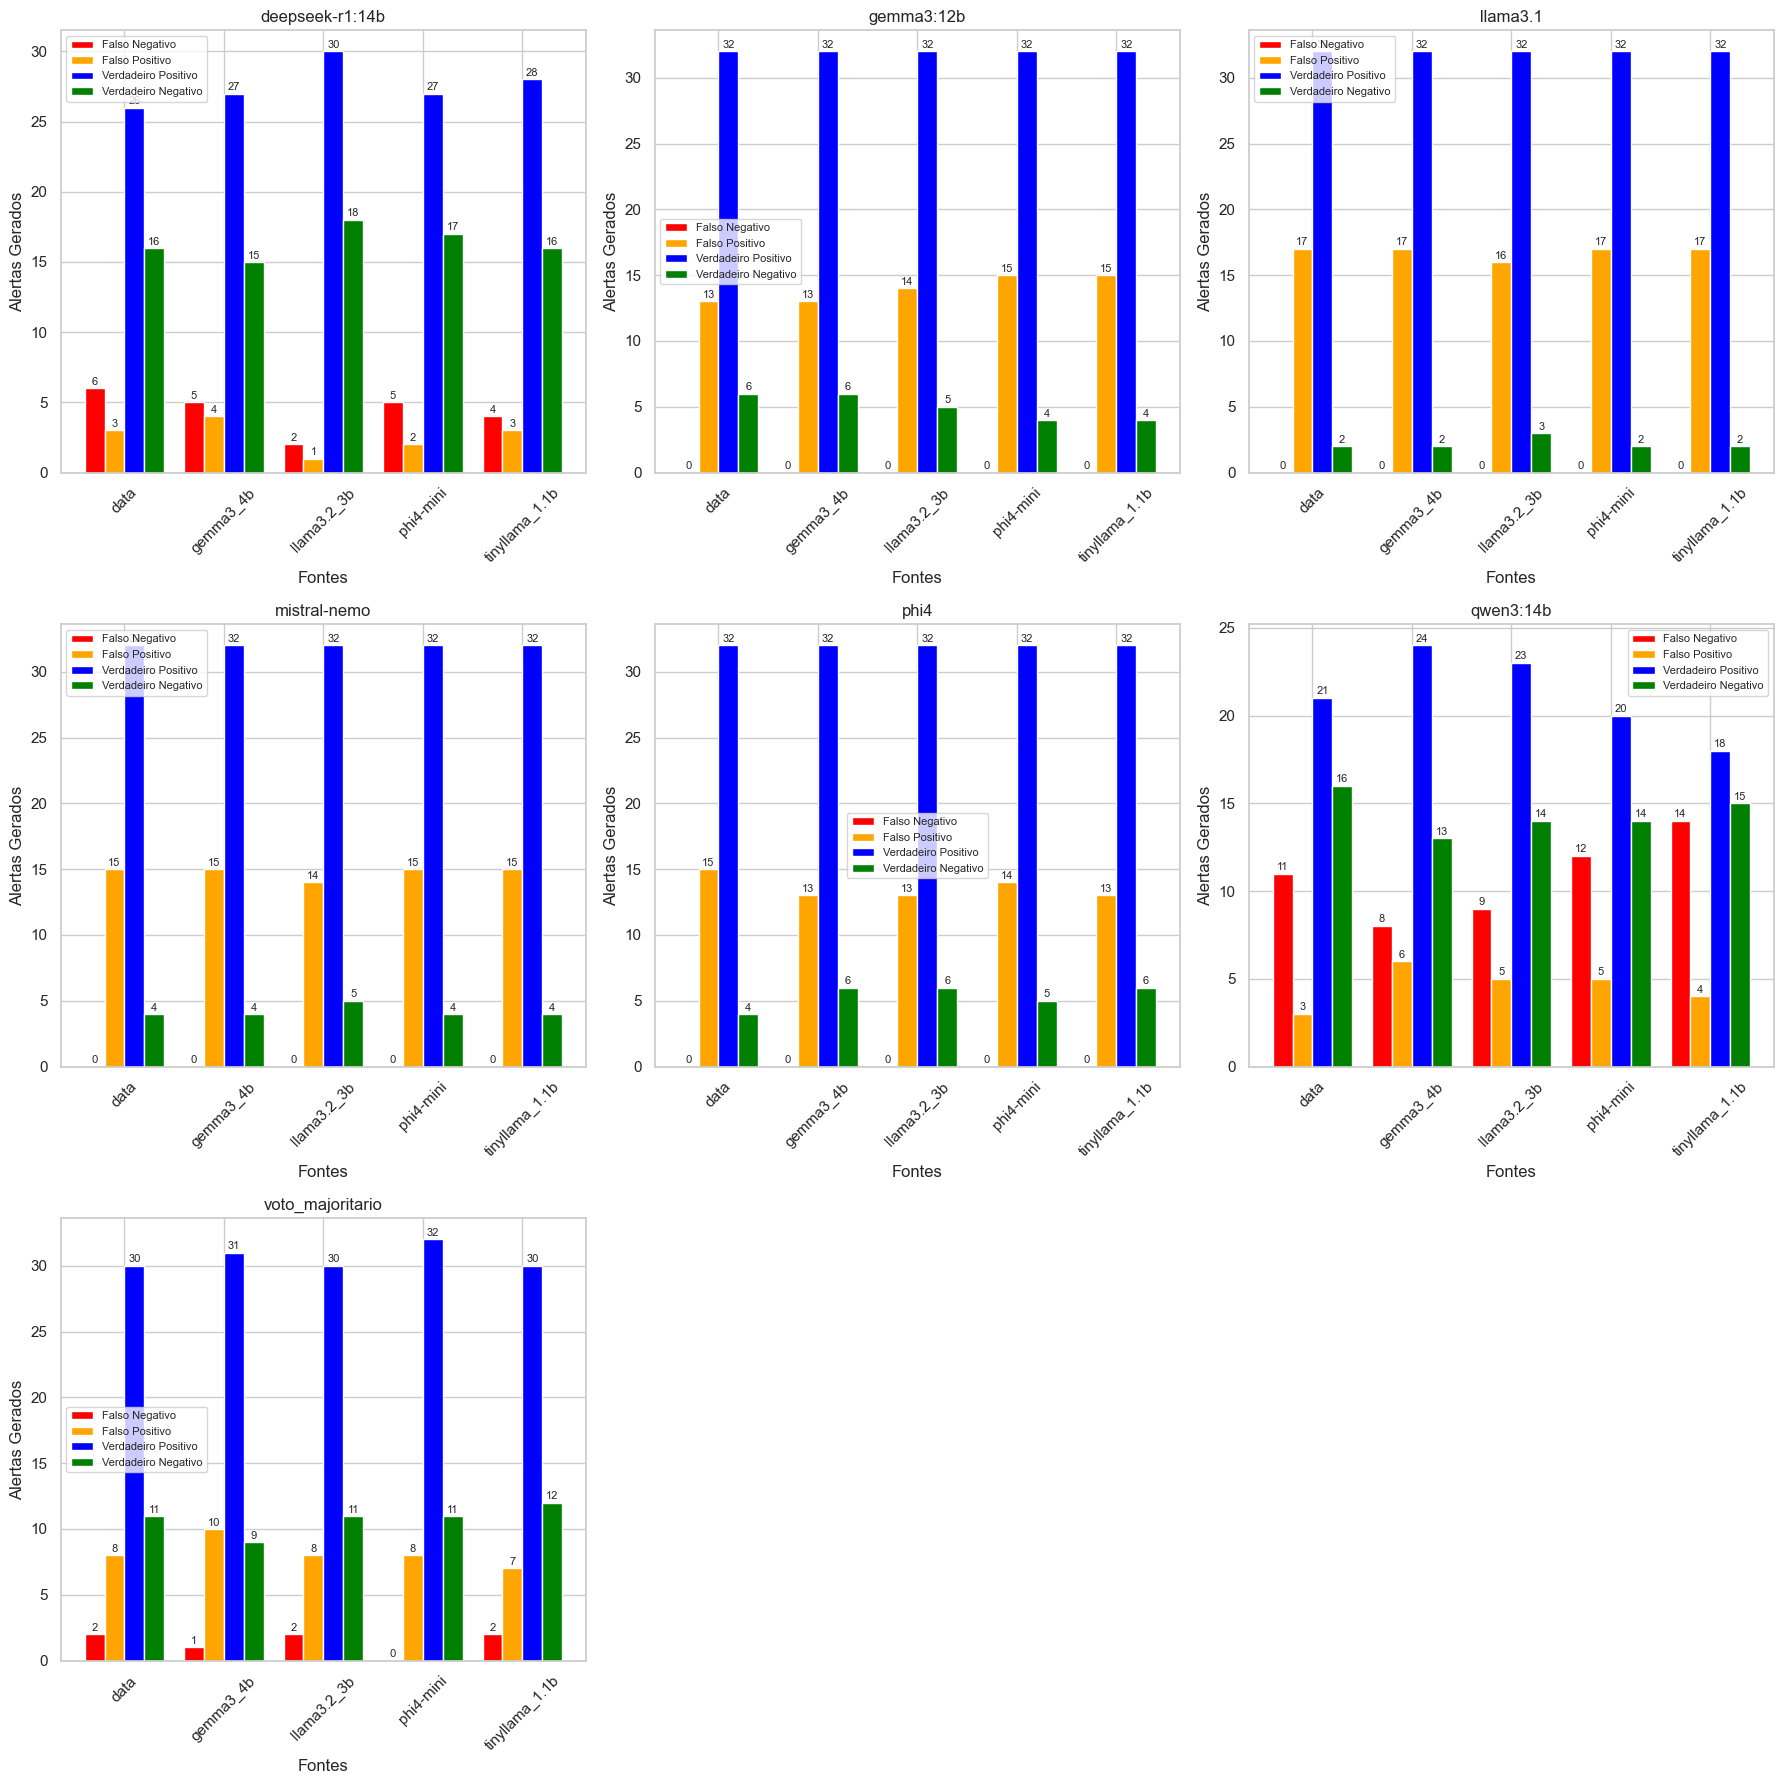

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

# Número de gráficos
majoritario = resultado_pivot_voto.copy()
majoritario['model'] = 'voto_majoritario'
majoritario.columns.name = None
juntar.append(majoritario.rename(columns={'fonte':'model_font'}))

for i in juntar:
    display(i)

n = len(juntar)

# Definir número de colunas (ajustável conforme necessidade)
num_cols = 3  # ou 2, 4, conforme o espaço
num_rows = math.ceil(n / num_cols)

# Criar os subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(6 * num_cols, 6 * num_rows))
axs = axs.flatten()  # Facilita o acesso aos eixos

for i, df in enumerate(juntar):
    ax = axs[i]
    bar_width = 0.2
    index = np.arange(len(df))

    if 'falso_negativo' in df.columns:
        bars_fn = ax.bar(index, df['falso_negativo'], bar_width, label='Falso Negativo', color='red')
        for bar in bars_fn:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f'{bar.get_height():.0f}', 
                    ha='center', va='bottom', fontsize=8)

    if 'falso_positivo' in df.columns:
        bars_fp = ax.bar(index + 1 * bar_width, df['falso_positivo'], bar_width, label='Falso Positivo', color='orange')
        for bar in bars_fp:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f'{bar.get_height():.0f}', 
                    ha='center', va='bottom', fontsize=8)

    if 'verdadeiro_positivo' in df.columns:
        bars_vp = ax.bar(index + 2 * bar_width, df['verdadeiro_positivo'], bar_width, label='Verdadeiro Positivo', color='blue')
        for bar in bars_vp:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f'{bar.get_height():.0f}', 
                    ha='center', va='bottom', fontsize=8)

    if 'verdadeiro_negativo' in df.columns:
        bars_vn = ax.bar(index + 3 * bar_width, df['verdadeiro_negativo'], bar_width, label='Verdadeiro Negativo', color='green')
        for bar in bars_vn:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f'{bar.get_height():.0f}', 
                    ha='center', va='bottom', fontsize=8)

    ax.set_xlabel('Fontes')
    ax.set_ylabel('Alertas Gerados')
    ax.set_title(f'{df["model"].iloc[0]}')
    ax.set_xticks(index + 1.5 * bar_width)
    ax.set_xticklabels(df['model_font'], rotation=45)
    ax.legend(fontsize=8)

# Remove subplots extras, caso existam
for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.savefig('result/inferencias_em_grade.png')
plt.show()
